In [1]:
import torch
import torchvision
import ignite

print(*map(lambda m: ": ".join((m.__name__, m.__version__)), (torch, torchvision, ignite)), sep="\n")

torch: 2.2.0+cu118
torchvision: 0.17.0+cu118
ignite: 0.4.13


In [2]:
import os
import logging
import matplotlib.pyplot as plt

import numpy as np
from PIL import Image
from skimage import color

from torchsummary import summary

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dset
import torchvision.utils as vutils

from ignite.engine import Engine, Events
import ignite.distributed as idist

In [3]:
ignite.utils.manual_seed(999)

In [4]:
ignite.utils.setup_logger(name="ignite.distributed.auto.auto_dataloader", level=logging.WARNING)
ignite.utils.setup_logger(name="ignite.distributed.launcher.Parallel", level=logging.WARNING)

<Logger ignite.distributed.launcher.Parallel (WARNING)>

In [5]:
class NPZDataset(Dataset):
    def __init__(self, npz_files_directory, transform=None):
        self.npz_files_directory = npz_files_directory
        self.transform = transform

        # 모든 npz 파일의 경로를 리스트로 저장
        self.npz_file_paths = [os.path.join(npz_files_directory, f) for f in os.listdir(npz_files_directory) if f.endswith('.npz')]
        
        # 각 파일 내 이미지의 수를 확인하고, 총 이미지 수를 계산
        self.lengths = [len(np.load(f)['images']) for f in self.npz_file_paths]
        self.total_images = sum(self.lengths)

    def __len__(self):
        return self.total_images

    def __getitem__(self, idx):
        # 적절한 npz 파일 찾기
        file_idx = next(i for i, v in enumerate(np.cumsum(self.lengths)) if v > idx)
        image_idx = idx - (np.cumsum(self.lengths)[file_idx - 1] if file_idx > 0 else 0)

        # 이미지 로드
        file_path = self.npz_file_paths[file_idx]
        with np.load(file_path) as npz_file:
            image = npz_file['images'][image_idx]
            image = np.expand_dims(image, axis = 2)
            image = np.repeat(image, 3, axis = 2)
            # lab_image = color.rgb2lab(image)
        # 이미지를 PIL 이미지로 변환
        image = Image.fromarray(image)
        # lab_tensor = torch.tensor(lab_image).permute(2, 0, 1).float()
        # 변환 적용
        if self.transform:
            image = self.transform(image)

        return image


In [6]:
image_size = 64

data_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
])

# NPZ 파일들이 있는 디렉토리
npz_files_directory = "datasets"

# 데이터셋 생성
dataset = NPZDataset(npz_files_directory=npz_files_directory, transform=data_transform)   


# 학습 데이터셋과 테스트 데이터셋 분리
train_dataset = torch.utils.data.Subset(dataset, torch.arange(len(dataset) - 3000))
test_dataset = torch.utils.data.Subset(dataset, torch.arange(len(dataset) - 3000, len(dataset)))


In [7]:
print(len(train_dataset))
print(len(test_dataset))

10276
3000


In [8]:
batch_size = 128

train_dataloader = idist.auto_dataloader(
    train_dataset, 
    batch_size=batch_size, 
    num_workers=8, 
    shuffle=True, 
    drop_last=True,
)

test_dataloader = idist.auto_dataloader(
    test_dataset, 
    batch_size=batch_size, 
    num_workers=8, 
    shuffle=False, 
    drop_last=True,
)

# real_batch = next(iter(train_dataloader))
# print(real_batch.shape)

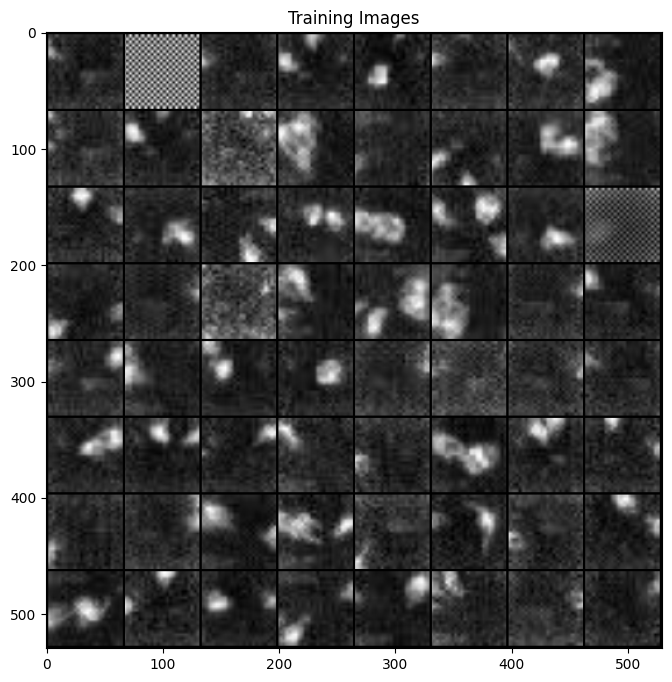

torch.Size([128, 3, 64, 64])


In [9]:
real_batch = next(iter(train_dataloader))
# print(real_batch.shape)
plt.figure(figsize=(8, 8))
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[:64], padding = 2, normalize=True).cpu(),(1, 2, 0)))
plt.show()
print(real_batch.shape)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


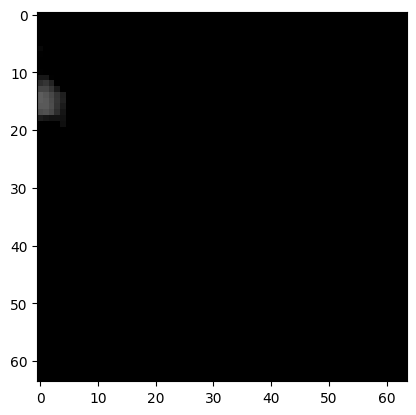

tensor(0.9922)
tensor(-1.)


In [10]:
plt.imshow(np.transpose(real_batch[0], (1, 2, 0)))
plt.show()
print(real_batch.max())
print(real_batch.min())

In [11]:
latent_dim = 200

In [12]:
class Generator3x64x64(nn.Module):
    def __init__(self, latent_dim):
        super(Generator3x64x64, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_dim, out_channels=512, 
                               kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # state size. 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # final state size. 3 x 64 x 64
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [13]:
netG = idist.auto_model(Generator3x64x64(latent_dim))

2024-02-13 11:57:35,961 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model


In [14]:
idist.device()

device(type='cuda')

In [15]:
summary(netG, (latent_dim, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,638,400
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [16]:
class Discriminator3x64x64(nn.Module):
    def __init__(self):
        super(Discriminator3x64x64, self).__init__()
        self.model = nn.Sequential(
            # input is 1 x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            # nn.SiLU(0.2, inplace=True),
            nn.SiLU(inplace=True),
            # state size. 64 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            # nn.SiLU(0.2, inplace=True),
            nn.SiLU(inplace=True),
            # state size. 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            # nn.SiLU(0.2, inplace=True),
            nn.SiLU(inplace=True),
            # state size. 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            # nn.SiLU(0.2, inplace=True),
            nn.SiLU(inplace=True),
            # state size. 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [17]:
netD = idist.auto_model(Discriminator3x64x64())
summary(netD, (3, 64, 64))

2024-02-13 11:57:40,732 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
            Conv2d-2           [-1, 64, 32, 32]           3,072
              SiLU-3           [-1, 64, 32, 32]               0
              SiLU-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 16, 16]         131,072
            Conv2d-6          [-1, 128, 16, 16]         131,072
       BatchNorm2d-7          [-1, 128, 16, 16]             256
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              SiLU-9          [-1, 128, 16, 16]               0
             SiLU-10          [-1, 128, 16, 16]               0
           Conv2d-11            [-1, 256, 8, 8]         524,288
           Conv2d-12            [-1, 256, 8, 8]         524,288
      BatchNorm2d-13            [-1, 256, 8, 8]             512
      BatchNorm2d-14            [-1, 25

In [18]:
criterion = nn.BCELoss()

In [19]:
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=idist.device())

In [20]:
optimizerD = idist.auto_optim(
    optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
)

optimizerG = idist.auto_optim(
    optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
)

In [21]:
real_label = 1
fake_label = 0


def training_step(engine, data):
    netG.train()
    netD.train()

    netD.zero_grad()

    real = data.to(idist.device())
    b_size = real.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=idist.device())

    output1 = netD(real).view(-1)
    errD_real = criterion(output1, label)
    errD_real.backward()

    noise = torch.randn(b_size, latent_dim, 1, 1, device=idist.device())
    fake = netG(noise)
    label.fill_(fake_label)
    
    output2 = netD(fake.detach()).view(-1)
    errD_fake = criterion(output2, label)
    errD_fake.backward()
    errD = errD_real + errD_fake
    optimizerD.step()


    netG.zero_grad()
    label.fill_(real_label) 

    output3 = netD(fake).view(-1)
    errG = criterion(output3, label)
    errG.backward()
    optimizerG.step()

    return {
        "Loss_G" : errG.item(),
        "Loss_D" : errD.item(),
        "D_x": output1.mean().item(),
        "D_G_z1": output2.mean().item(),
        "D_G_z2": output3.mean().item(),
    }

In [22]:
trainer = Engine(training_step)

In [23]:
def initialize_fn(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [24]:
@trainer.on(Events.STARTED)
def init_weights():
    netD.apply(initialize_fn)
    netG.apply(initialize_fn)

In [25]:
G_losses = []
D_losses = []

@trainer.on(Events.ITERATION_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    G_losses.append(o["Loss_G"])
    D_losses.append(o["Loss_D"])

In [26]:
img_list = []

@trainer.on(Events.ITERATION_COMPLETED(every=500))
def store_images(engine):
    with torch.no_grad():
        fake = netG(fixed_noise).cpu()
    img_list.append(fake)

In [27]:
from ignite.metrics import FID, InceptionScore

In [28]:
fid_metric = FID(device=idist.device())

In [29]:
is_metric = InceptionScore(device=idist.device(), output_transform=lambda x: x[0])

In [30]:
import PIL.Image as Image


def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)


def evaluation_step(engine, batch):
    with torch.no_grad():
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=idist.device())
        netG.eval()
        fake_batch = netG(noise)
        fake = interpolate(fake_batch)
        # print(fake.shape)
        real = interpolate(batch)
        # print(real.shape)
        return fake, real

In [31]:
evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, "fid")
is_metric.attach(evaluator, "is")

In [32]:
fid_values = []
is_values = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(test_dataloader,max_epochs=1)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    is_score = metrics['is']
    fid_values.append(fid_score)
    is_values.append(is_score)
    print(f"Epoch [{engine.state.epoch}/100] Metric Scores")
    print(f"*   FID : {fid_score:4f}")
    print(f"*    IS : {is_score:4f}")

In [33]:
from ignite.metrics import RunningAverage


RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, 'Loss_G')
RunningAverage(output_transform=lambda x: x["Loss_D"]).attach(trainer, 'Loss_D')

In [34]:
from ignite.contrib.handlers import ProgressBar


ProgressBar().attach(trainer, metric_names=['Loss_G','Loss_D'])
ProgressBar().attach(evaluator)

/home/gpuadmin/anaconda3/envs/torch/lib/python3.8/site-packages/ignite/contrib/handlers/tqdm_logger.py:126: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [35]:
def training(*args):
    trainer.run(train_dataloader, max_epochs=100)

In [36]:
real_batch = next(iter(train_dataloader))
print(real_batch.shape)

torch.Size([128, 3, 64, 64])


In [37]:
with idist.Parallel(backend='nccl') as parallel:
    parallel.run(training)

Epoch [1/100] Metric Scores
*   FID : 0.455307
*    IS : 1.019543


Epoch [2/100] Metric Scores
*   FID : 0.065639
*    IS : 1.080456


Epoch [3/100] Metric Scores
*   FID : 0.044041
*    IS : 1.019203


Epoch [4/100] Metric Scores
*   FID : 0.047694
*    IS : 1.028607


Epoch [5/100] Metric Scores
*   FID : 0.077649
*    IS : 1.076659


Epoch [6/100] Metric Scores
*   FID : 0.045508
*    IS : 1.037563


Epoch [7/100] Metric Scores
*   FID : 0.046887
*    IS : 1.023734


Epoch [8/100] Metric Scores
*   FID : 0.134776
*    IS : 1.024261


Epoch [9/100] Metric Scores
*   FID : 0.060619
*    IS : 1.022596


Epoch [10/100] Metric Scores
*   FID : 0.048034
*    IS : 1.016468


Epoch [11/100] Metric Scores
*   FID : 0.093609
*    IS : 1.019454


Epoch [12/100] Metric Scores
*   FID : 0.046509
*    IS : 1.011656


Epoch [13/100] Metric Scores
*   FID : 0.047985
*    IS : 1.017198


Epoch [14/100] Metric Scores
*   FID : 0.052637
*    IS : 1.008946


Epoch [15/100] Metric Scores
*   FID : 0.064946
*    IS : 1.012725


Epoch [16/100] Metric Scores
*   FID : 0.045035
*    IS : 1.008741


Epoch [17/100] Metric Scores
*   FID : 0.044153
*    IS : 1.011321


Epoch [18/100] Metric Scores
*   FID : 0.366461
*    IS : 1.008959


Epoch [19/100] Metric Scores
*   FID : 0.113081
*    IS : 1.015583


Epoch [20/100] Metric Scores
*   FID : 0.046051
*    IS : 1.007467


Epoch [21/100] Metric Scores
*   FID : 0.572244
*    IS : 1.005440


Epoch [22/100] Metric Scores
*   FID : 0.607897
*    IS : 1.005447


Epoch [23/100]: [76/80]  95%|█████████▌, Loss_G=8.39, Loss_D=0.000641 [00:15<00:01]Engine run is terminating due to exception: 


KeyboardInterrupt: 

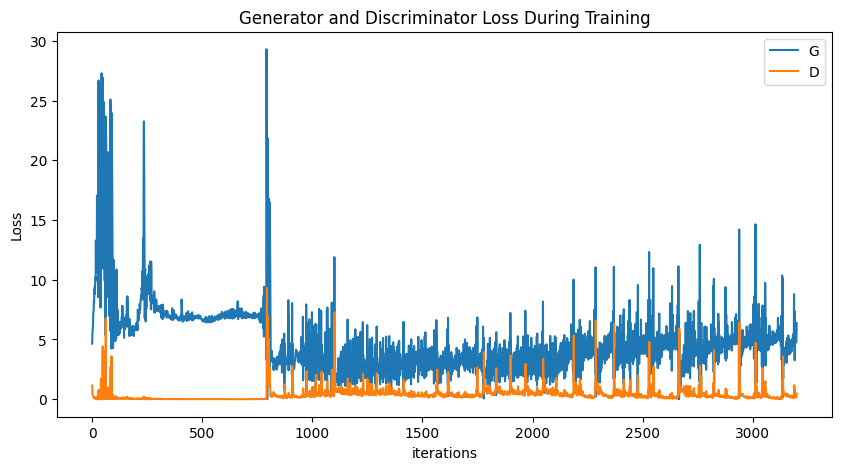

In [ ]:
%matplotlib inline

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D") 
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

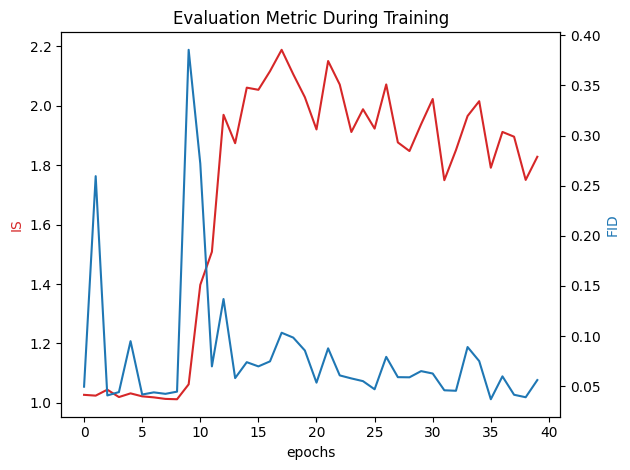

In [ ]:
fig, ax1 = plt.subplots()

plt.title("Evaluation Metric During Training")

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('IS', color=color)
ax1.plot(is_values, color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('FID', color=color)
ax2.plot(fid_values, color=color)

fig.tight_layout()

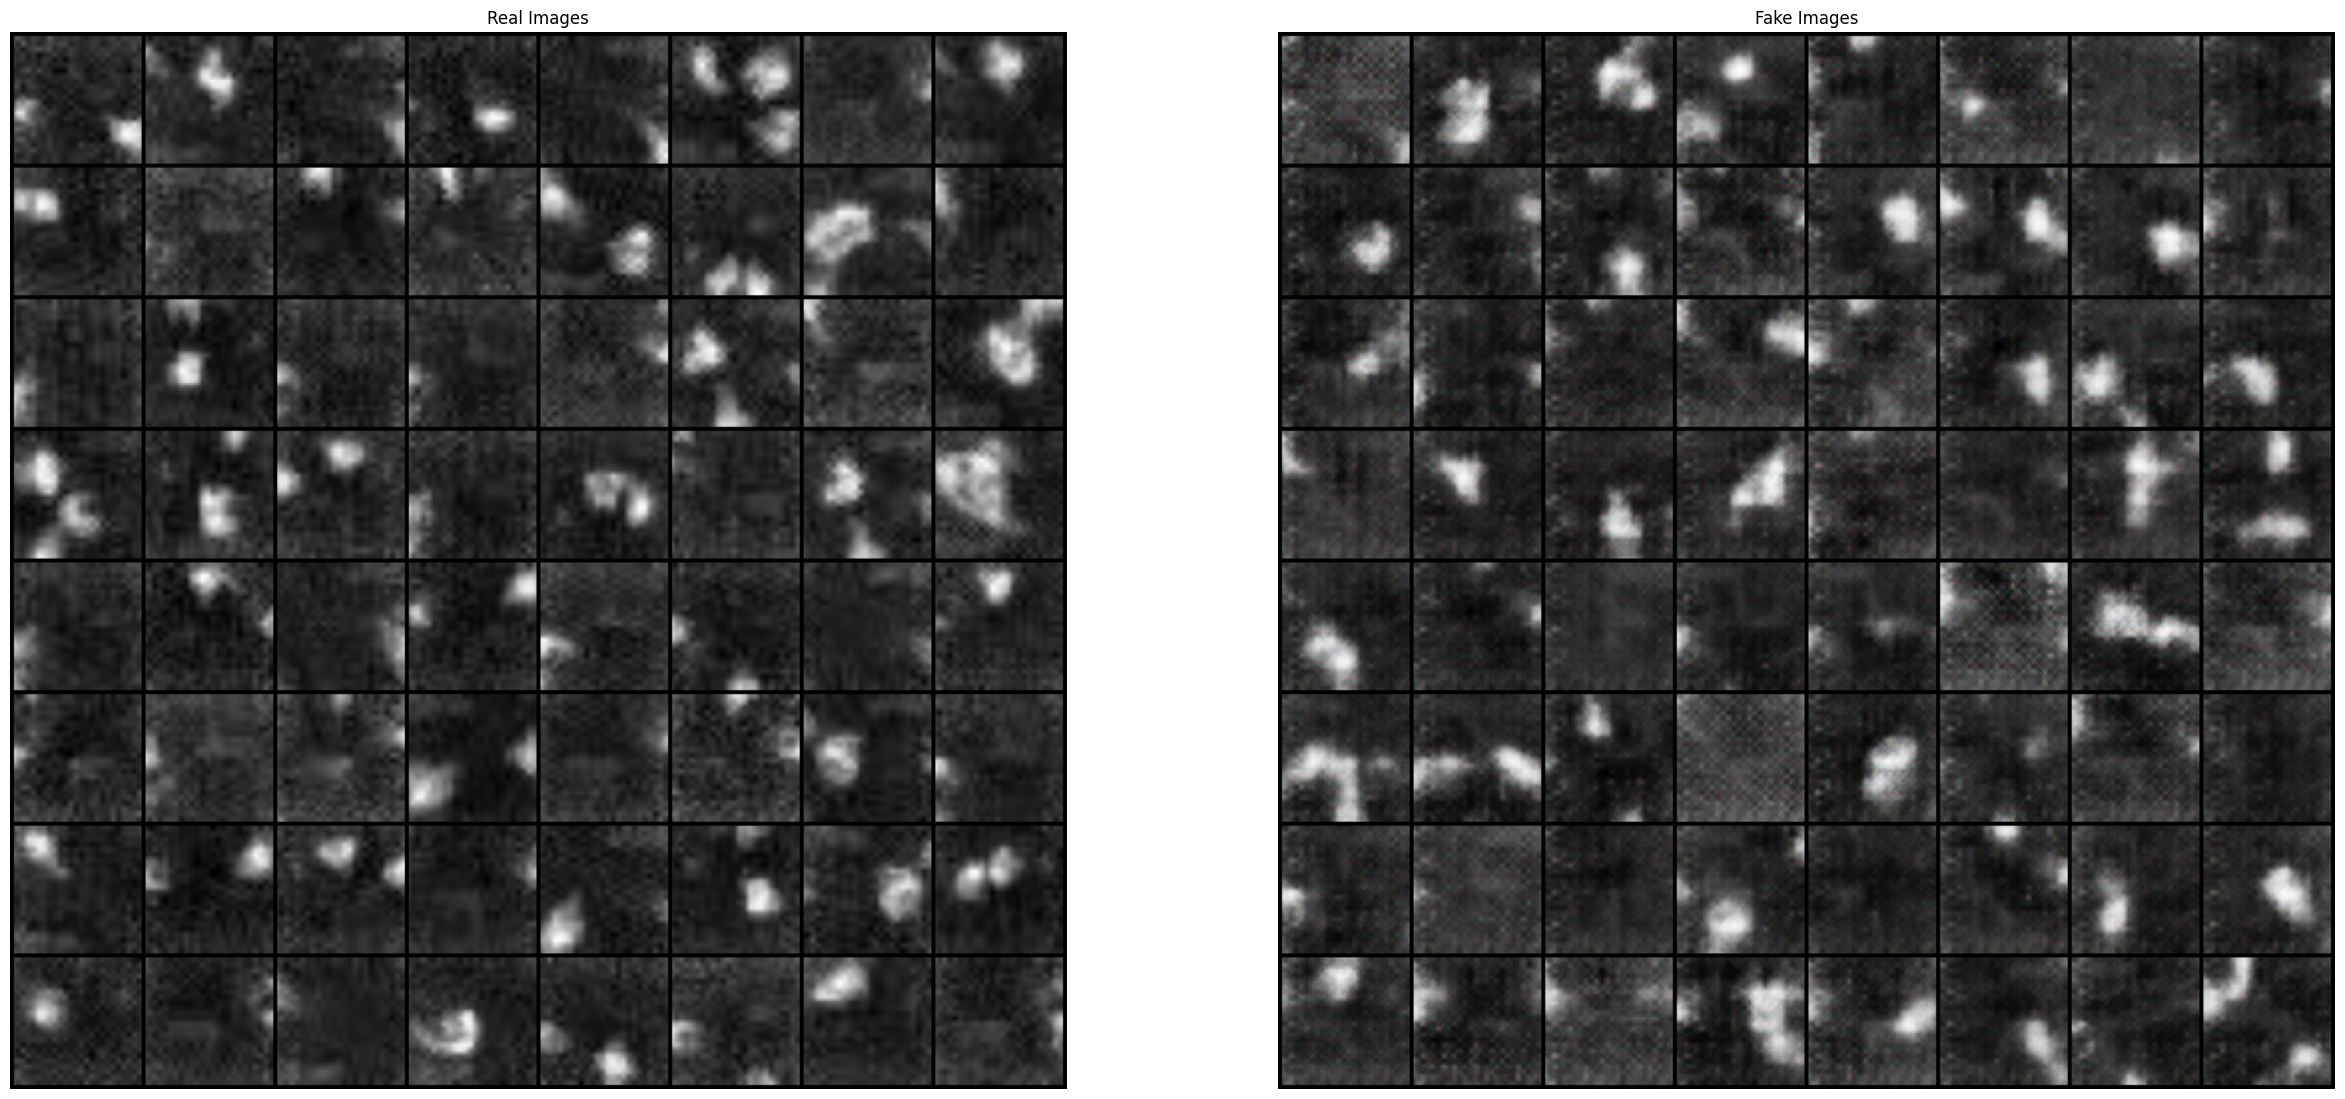

In [ ]:
%matplotlib inline

# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1][:64], padding=2, normalize=True).cpu(),(1,2,0)))